In [1]:
import pandas as pd
import re

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'


# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [2]:
data['date'] = pd.to_datetime(data['date'])

data = data.sort_values(by=['user', 'date'])

In [3]:
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

data.head(10)

,date,user,message,stream,first_message
10789,2024-05-05 16:24:24+00:00,00001joel,you ever tried snus?,4,1
12356,2024-05-05 19:53:34+00:00,00001joel,you have a boyfriend???,4,0
12361,2024-05-05 19:54:18+00:00,00001joel,:(,4,0
13132,2024-05-06 15:38:41+00:00,00001joel,whats your favourite snus!,5,0
38876,2024-05-17 18:36:08+00:00,00ramez00,my friend loves u,14,1
102451,2024-06-11 15:38:40+00:00,062_davi,hello,37,1
156529,2024-07-06 12:45:45+00:00,082274699958,doro love greets from indonesian❤️,55,1
149512,2024-07-03 12:11:25+00:00,09logdog,darova,53,1
156925,2024-07-06 13:46:29+00:00,0_0hakan,you have to guess :dd,55,1
109293,2024-06-13 15:50:11+00:00,0_OS_0,Change your sword = ez win,39,1


In [4]:
data[data['user'] == 'balintboss']

,date,user,message,stream,first_message
21,2024-05-01 15:06:18+00:00,balintboss,ready to 1984,0,1
60,2024-05-01 15:10:39+00:00,balintboss,ADHD,0,0
69,2024-05-01 15:11:14+00:00,balintboss,hell no,0,0
84,2024-05-01 15:12:31+00:00,balintboss,hike,0,0
146,2024-05-01 15:18:24+00:00,balintboss,o7,0,0
...,...,...,...,...,...
175173,2024-07-13 19:17:41+00:00,balintboss,@allow433 she is a trilioner,61,0
175189,2024-07-13 19:19:13+00:00,balintboss,I'm banned on typhu chanel LOL but I never wat...,61,0
175203,2024-07-13 19:20:18+00:00,balintboss,monday :),61,0
175218,2024-07-13 19:21:44+00:00,balintboss,@ErPardi ??? you know how time zones work?,61,0


In [5]:
data['first_message'].describe()

count    175257.000000
mean          0.028438
std           0.166222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: first_message, dtype: float64

In [9]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()

# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream
})


stream_stats

,first_messages,total_messages
stream,,
0,177,1985
1,150,3046
2,104,2754
3,84,2375
4,76,2455
...,...,...
57,78,2294
58,55,2172
59,134,2552


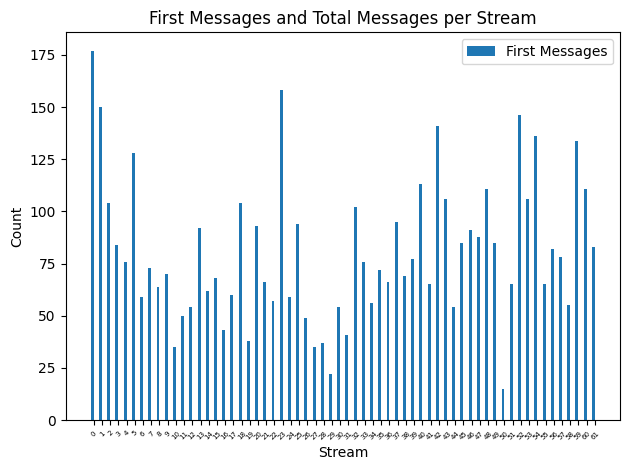

In [20]:
import matplotlib.pyplot as plt

# Plot the chart
fig, ax = plt.subplots()

# Bar width
bar_width = 0.35

# Bar positions
index = range(len(stream_stats))

# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], bar_width, label='First Messages')

# Labels and title
ax.set_xlabel('Stream')
ax.set_ylabel('Count')
ax.set_title('First Messages')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stream_stats.index)
ax.legend()

ax.set_xlabel('Stream', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('First Messages and Total Messages per Stream', fontsize=12)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stream_stats.index, fontsize=5)  # Adjust x-tick labels font size
ax.legend(fontsize=10)

# Display the plot
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.xticks()
plt.tight_layout()
plt.show()


In [23]:
data[data['stream']== 50].head(10)

,date,user,message,stream,first_message
143322,2024-06-29 12:06:23+00:00,1206paul_,we are setting it up again brb,50,0
143325,2024-06-29 12:06:34+00:00,1206paul_,pin pla,50,0
143783,2024-06-29 13:11:06+00:00,1206paul_,dude they took the phone with the server on it,50,0
143784,2024-06-29 13:11:08+00:00,1206paul_,omE,50,0
143796,2024-06-29 13:12:13+00:00,1206paul_,welp,50,0
143802,2024-06-29 13:12:53+00:00,1206paul_,nice,50,0
143904,2024-06-29 13:20:43+00:00,1206paul_,fixing,50,0
143187,2024-06-29 11:58:25+00:00,55Dash,yo,50,0
143204,2024-06-29 11:59:02+00:00,55Dash,the gkey guy,50,0
143221,2024-06-29 12:00:29+00:00,55Dash,real,50,0


In [24]:
stream_stats.describe()

,first_messages,total_messages
count,62.000000,62.000000
mean,80.387097,2826.725806
std,34.122900,1180.928284
min,15.000000,796.000000
25%,57.500000,2010.250000
50%,74.500000,2573.000000
75%,100.250000,3429.250000
max,177.000000,7033.000000


In [29]:
# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

In [30]:
stream_stats.head(10)

,first_messages,total_messages,stream_length
stream,,,
0,177,1985,17697.0
1,150,3046,17831.0
2,104,2754,19147.0
3,84,2375,17451.0
4,76,2455,18734.0
5,128,4276,20382.0
6,59,2004,16563.0
7,73,2340,17773.0
8,64,2838,18686.0
